In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')


merged_path = 'drive/MyDrive/comp3merge.csv'
fd=pd.read_csv(merged_path)
ll= 'drive/MyDrive/final_meta.csv'
ld= pd.read_csv(ll)
final_df = pd.merge(fd,ld, on=['Close'],how='inner')

final_df.rename(columns={'Open_x': 'Open'}, inplace=True)
data_sorted = final_df.sort_values(by='date', ascending=True)
column11=['Open','Adj Close','Predicted_Label']
data_sorted = data_sorted[column11]
data_sorted.to_csv('/content/drive/My Drive/final_pred_sorted3.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/final_pred_sorted3.csv')


Mounted at /content/drive


   Date Action       Price
0    67    Buy  152.867798
1    83   Sell  197.150818
2    95    Buy  160.409805
3   123   Sell  169.989639
4   158    Buy  183.355453
5   181   Sell  207.879440
6   195    Buy  169.320343
7   215   Sell  292.889252
8   285    Buy  333.386261
9   355   Sell  242.922241
Final Portfolio Value: $19467.21
Total Returns: 94.67%
Sharpe Ratio: 1.42
Maximum Drawdown: -71.62%
Number of Trades Executed: 10
Win Ratio: 80.00%


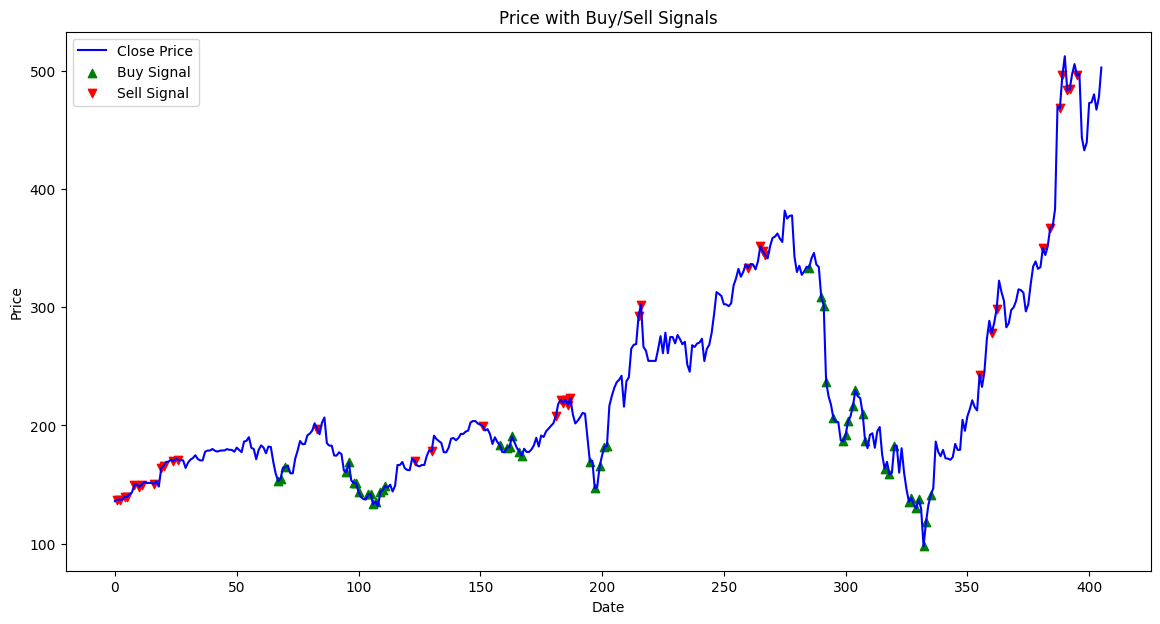

In [3]:
def calculate_rsi(data, window):
    delta = data['Adj Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def generate_signals(data, rsi_window=15):
    data['RSI'] = calculate_rsi(data, rsi_window)
    data['Buy'] = np.where((data['RSI'] < 40) & (data['Predicted_Label'] == 1), data['Adj Close'], np.nan)
    data['Sell'] = np.where((data['RSI'] > 75) & (data['Predicted_Label'] == 0), data['Adj Close'], np.nan)
    return data

def simulate_trading(data):
    initial_cash = 10000
    cash = initial_cash
    shares = 0
    buy_price = []
    sell_price = []
    trades = 0
    wins = 0
    transactions = []

    portfolio_values = []
    cash_balances = []

    for index, row in data.iterrows():
        if not np.isnan(row['Buy']):
            if cash >= row['Adj Close']:
                shares = cash // row['Adj Close']
                cash -= shares * row['Adj Close']
                buy_price.append(row['Adj Close'])
                trades += 1
                transactions.append((row.name, 'Buy', row['Adj Close']))
        elif not np.isnan(row['Sell']) and shares > 0:
            cash += shares * row['Adj Close']
            shares = 0
            sell_price.append(row['Adj Close'])
            trades += 1
            transactions.append((row.name, 'Sell', row['Adj Close']))
            if sell_price[-1] > buy_price[-1]:
                wins += 1

        portfolio_value = cash + shares * row['Adj Close']
        portfolio_values.append(portfolio_value)
        cash_balances.append(cash)

    final_portfolio_value = cash + shares * data['Adj Close'].iloc[-1]
    returns = (final_portfolio_value - initial_cash) / initial_cash
    win_ratio = wins / (trades / 2) if trades > 0 else 0
    daily_returns = data['Adj Close'].pct_change()
    mean_daily_return = daily_returns.mean()
    std_daily_return = daily_returns.std()
    sharpe_ratio = (mean_daily_return) / std_daily_return * np.sqrt(252)
    data['Portfolio Value'] = portfolio_values
    data['Cash Balance'] = cash_balances
    data['Roll Max'] = data['Portfolio Value'].cummax()
    data['Drawdown'] = data['Portfolio Value'] / data['Roll Max'] - 1
    max_drawdown = data['Drawdown'].min()
    data['Cumulative Returns'] = (data['Portfolio Value'] - initial_cash) / initial_cash


    transactions_df = pd.DataFrame(transactions, columns=['Date', 'Action', 'Price'])
    print(transactions_df)

    return final_portfolio_value, returns, sharpe_ratio, max_drawdown, trades, win_ratio, data

data = generate_signals(data)
final_portfolio_value, returns, sharpe_ratio, max_drawdown, trades, win_ratio, data = simulate_trading(data)
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Total Returns: {returns:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Number of Trades Executed: {trades}")
print(f"Win Ratio: {win_ratio:.2%}")

plt.figure(figsize=(14, 7))
plt.plot(data['Adj Close'], label='Close Price', color='blue')
plt.scatter(data.index, data['Buy'], label='Buy Signal', marker='^', color='green')
plt.scatter(data.index, data['Sell'], label='Sell Signal', marker='v', color='red')
plt.title('Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



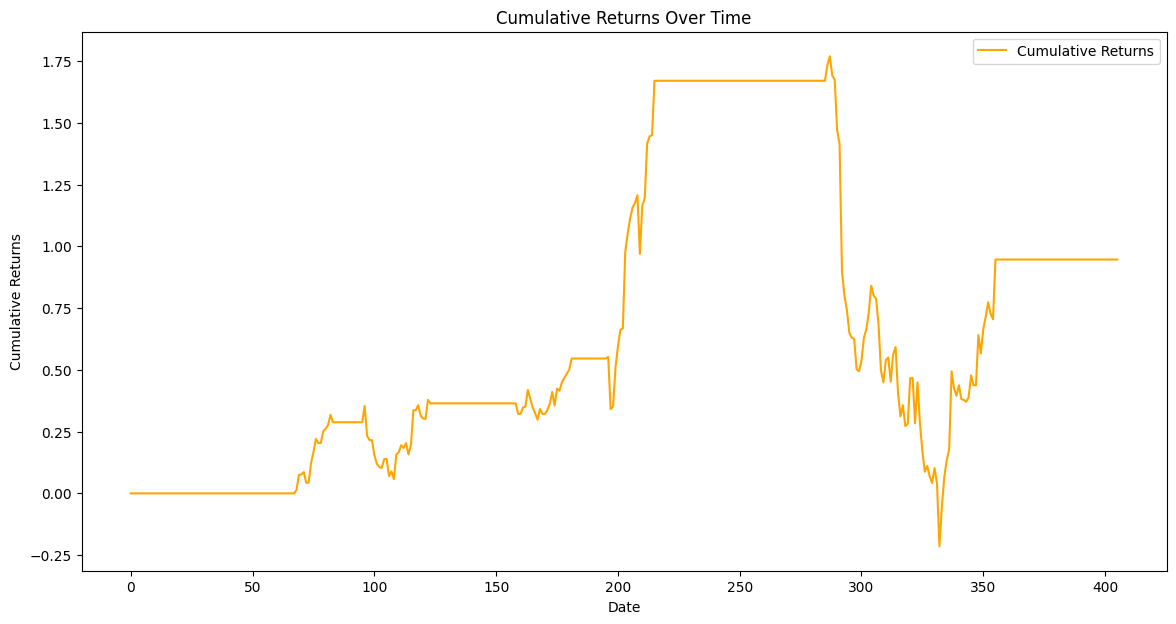

In [4]:

plt.figure(figsize=(14, 7))
plt.plot(data['Cumulative Returns'], label='Cumulative Returns', color='orange')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()
